# Arima
This file contains the ARIMA model that is used to forecast the COVID-19 cases

### Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import plotly
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# To import the main.py file
sys.path.append('../')
from python_files import main

In [2]:
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

### Data Preprocessing

In [3]:
def get_data():
    confirmed_global, deaths_global, recovered_global, country_cases = main.collect_data()
    
    recovered = recovered_global.groupby('country').sum().T
    deaths = deaths_global.groupby('country').sum().T
    confirmed = confirmed_global.groupby('country').sum().T
    
    deaths.index = pd.to_datetime(deaths.index, infer_datetime_format=True)
    recovered.index = pd.to_datetime(recovered.index, infer_datetime_format=True)
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format=True)
    
    return deaths, recovered, confirmed

In [4]:
def create_data_frame(dataframe, country):
    deaths, recovered, confirmed = get_data()

    if dataframe == 'deaths':
        data = pd.DataFrame(index=deaths.index, data=deaths[country].values, columns=['Total'])

    elif dataframe == 'recovered':
        data = pd.DataFrame(index=recovered.index, data=recovered[country].values, columns=['Total'])

    elif dataframe == 'confirmed':
        data = pd.DataFrame(index=confirmed.index, data=confirmed[country].values, columns=['Total'])

    data = data[(data != 0).all(1)]
    
    data['Date'] = data.index
    cols = [data.columns[-1]] + [col for col in data if col != data.columns[-1]]
    data = data[cols]   

    return data

### Graphing

In [5]:
def plot_forecast(data,forecast):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=data['Date'], y=data['Total'],
            mode='lines',
            name='Present'
        )
    )

    fig.add_trace(
        go.Scatter(
            x=forecast.index, y=forecast['cumulative'],
            mode='lines',
            name='Predictions'
        )
    )

    fig.update_layout(
        title={
            'text': 'Forecasted Results',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Date',
        yaxis_title='Cases',
        legend_title='Legend',
        font={
            'family': 'Arial',
            'size': 15,
            'color': 'black'
        }
    )

    return fig

### Model Training and Testing

In [6]:
def find_params(train_set):
    stepwise_model = auto_arima(
        train_set, start_p=0, start_q=0,
        max_p=1, max_q=1, m=7,
        start_P=0, start_Q=0, max_P=1, max_Q=1, seasonal=True,
        d=None, D=1, n_jobs=-1, trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    return stepwise_model

In [7]:
def predict_cases(stepwise_model, train, test):
    stepwise_model.fit(train)
    pred = stepwise_model.predict(n_periods=len(test))

    pred = pd.DataFrame(pred, index=test.index, columns=['Prediction'])
    pred =  pred.values.flatten()
   
    return pred

### Error Calculation

In [8]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Forecasting

In [9]:
def future_cases(order, seasonal_order, train, test, data):
    model = SARIMAX(
        data.diff()['Total'][1:],
        order=order,
        seasonal_order=seasonal_order
    )
    result = model.fit()

    forecast = result.predict(
        start=len(data),
        end=((len(data)-1) + 14)
    ).rename('Forecast')
    
    forecast_cumulative = []
    start = data['Total'][-1]

    for i in forecast.values:
        start = start + i
        forecast_cumulative.append(start)
    forecast['cumulative'] = forecast_cumulative
    graph = plot_forecast(data, forecast)

    return forecast_cumulative, graph

### Main Function

In [10]:
def arima_predict(df_name, country):
    data = create_data_frame(df_name,country)
    
    train = data['Total'][:len(data)*4//5].diff()[1:]
    test = data['Total'][len(data)*4//5:].diff()[1:]
    start = data['Total'][-len(test)-1]

    model = find_params(train)
    pred = predict_cases(model, train, test)
    predictions_cumulative=[]

    for i in pred :
        start = start + i
        predictions_cumulative.append(start)

    y_test_cumulative = data['Total'][-len(test):]

    MAPE = mape(y_test_cumulative, predictions_cumulative)

    order=model.get_params()['order']
    seasonal_order=model.get_params()['seasonal_order']
    forecast, graph = future_cases(order, seasonal_order, train, test, data)

    return forecast, graph, MAPE

### Example

In [11]:
forecast, graph, error = arima_predict("confirmed", "India")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3287.457, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=3180.111, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=3155.028, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=3206.281, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=3153.583, Time=0.55 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=3164.676, Time=0.34 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=3183.794, Time=0.41 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=3155.327, Time=1.04 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=3164.927, Time=0.71 sec
 ARIMA(0,1,1)(1,1,1)[7] intercept   : AIC=3149.950, Time=1.11 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=3150.346, Time=0.72 sec
 ARIMA(0,1,1)(1,1,0)[7] intercept   : AIC=3164.828, Time=0.63 sec
 ARIMA(0,1,1)(0,1,0)[7] intercept   : AIC=3207.428, Time=0.21 sec
 ARIMA(0,1,0)(1,1,1)[7] intercept   : AIC=3183.049, Time=0.78 sec
 ARIMA(1,1,1)(1,1,1)[7] intercept

In [12]:
print('Predictions for the next 2 weeks:')
for i in range(len(forecast)):
    print(int(forecast[i]))

Predictions for the next 2 weeks:
6066813
6148776
6237245
6324852
6412020
6500225
6584608
6659372
6741813
6830785
6918891
7006560
7095250
7180125


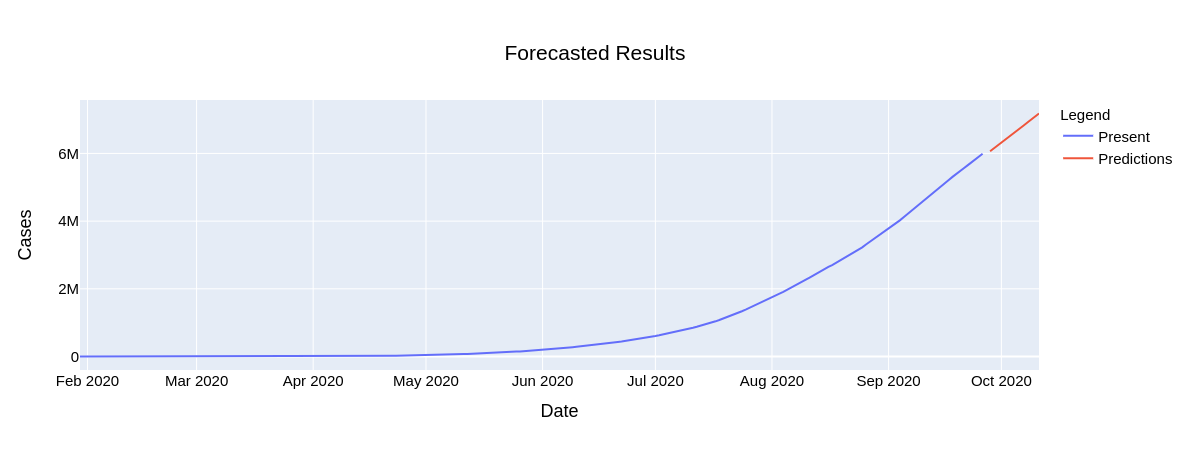

In [13]:
graph.show()

In [14]:
print(f"Allow an error of upto {error}%")

Allow an error of upto 5.348700927980979%
